In [33]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [2]:
# If on MacBook:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


In [16]:
# Step 1: Create a non-linear dataset (make_moons)

# make_moons generates a two-class dataset that is non-linear and slightly challenging but simple to work with

X, y = make_moons(
    n_samples=1000
    , noise=0.2
    , random_state=27)

In [17]:
# Step 2: Split the data into training and testing sets

# Random state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
    , random_state=27
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [5]:
# Step 3: Preprocess the data
# Standardize the features to ensure faster and more stable training of the neural network

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Convert the data to PyTorch tensors for compatibility with PyTorch

# NOTE: In some classifications models, 'y' dtype needs to be a 'longTensor' (torch.long) when using CrossEntropyLoss, as this loss_fn needs an index value for the classification, hence needs an integer, not float;

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [19]:
# Step 4: Define the neural network model

# This is a simple feedforward neural network with 2 hidden layers
class MoonsNN(nn.Module):
    def __init__(self):
        super(MoonsNN, self).__init__()
        # Input layer: 2 features as input
        # Hidden layer 1: 16 neurons with ReLU activation
        # Hidden layer 2: 8 neurons with ReLU activation
        # Output layer: 2 neurons (one for each class) with Softmax activation
        self.fc1 = nn.Linear(2, 16)  # First hidden layer
        self.fc2 = nn.Linear(16, 8)  # Second hidden layer
        self.fc3 = nn.Linear(8, 2)   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first hidden layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second hidden layer
        x = self.fc3(x)              # Output layer (logits)
        return x

In [20]:
# Initialize the model and move it to the selected device (CPU/GPU)
model = MoonsNN().to(device)
model

MoonsNN(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

In [21]:
# Step 5: Define the loss function and optimizer
# CrossEntropyLoss is used for classification problems

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(), lr=0.01)  # Adam optimizer with a learning rate of 0.01

In [27]:
# Number of epochs (iterations over the entire dataset)
n_epochs = 100

for epoch in range(n_epochs):
    # ===== Training =====
    model.train()  # Set the model to training mode

    # Forward pass: compute the predictions
    y_pred = model(X_train_tensor)

    # Compute the training loss
    loss = criterion(y_pred, y_train_tensor)

    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # ===== Evaluation every 10 epochs =====
    if (epoch + 1) % 10 == 0:
        # Calculate training accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            # Training accuracy
            y_train_pred_classes = torch.argmax(y_pred, dim=1)  # Get predicted class labels
            train_correct = (y_train_pred_classes == y_train_tensor).sum().item()
            train_accuracy = train_correct / y_train_tensor.size(0)

            # Test loss and accuracy
            y_test_pred = model(X_test_tensor)  # Forward pass on test data
            test_loss = criterion(y_test_pred, y_test_tensor).item()  # Test loss
            y_test_pred_classes = torch.argmax(y_test_pred, dim=1)  # Predicted class labels
            test_correct = (y_test_pred_classes == y_test_tensor).sum().item()
            test_accuracy = test_correct / y_test_tensor.size(0)

        # Print training and test results
        print(f"Epoch [{epoch + 1}/{n_epochs}], "
              f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [10/100], Train Loss: 0.0616, Train Accuracy: 0.9712, Test Loss: 0.0542, Test Accuracy: 0.9750
Epoch [20/100], Train Loss: 0.0613, Train Accuracy: 0.9712, Test Loss: 0.0542, Test Accuracy: 0.9750
Epoch [30/100], Train Loss: 0.0610, Train Accuracy: 0.9712, Test Loss: 0.0541, Test Accuracy: 0.9750
Epoch [40/100], Train Loss: 0.0608, Train Accuracy: 0.9712, Test Loss: 0.0542, Test Accuracy: 0.9750
Epoch [50/100], Train Loss: 0.0606, Train Accuracy: 0.9712, Test Loss: 0.0541, Test Accuracy: 0.9750
Epoch [60/100], Train Loss: 0.0605, Train Accuracy: 0.9712, Test Loss: 0.0539, Test Accuracy: 0.9750
Epoch [70/100], Train Loss: 0.0603, Train Accuracy: 0.9700, Test Loss: 0.0546, Test Accuracy: 0.9750
Epoch [80/100], Train Loss: 0.0599, Train Accuracy: 0.9712, Test Loss: 0.0559, Test Accuracy: 0.9750
Epoch [90/100], Train Loss: 0.0595, Train Accuracy: 0.9725, Test Loss: 0.0562, Test Accuracy: 0.9750
Epoch [100/100], Train Loss: 0.0594, Train Accuracy: 0.9738, Test Loss: 0.0553, Test Accura

In [31]:
import requests
from pathlib import Path
import torch # Import torch

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Load helper functions and modify plot_decision_boundary for multi-class
from helper_functions import plot_predictions, plot_decision_boundary as original_plot_decision_boundary

def plot_decision_boundary(model, X, y):
    # Plot decision boundaries of model
    model.to("cpu") # send model to CPU
    X, y = X.to("cpu"), y.to("cpu") # send data to CPU

    # Make predictions
    # Change here to handle multi-class output
    y_logits = model(X)
    y_pred_probs = torch.softmax(y_logits, dim=1) # Apply softmax to get probabilities
    y_pred = torch.argmax(y_pred_probs, dim=1) # Get predicted class (0 or 1)

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make predictions on grid data
    X_to_pred_on = torch.from_numpy(np.vstack((xx.ravel(), yy.ravel())).T).float()
    model.eval()
    with torch.no_grad():
        y_logits = model(X_to_pred_on)
        # Change here to handle multi-class output
        y_pred_probs = torch.softmax(y_logits, dim=1) # Apply softmax
        y_pred = torch.argmax(y_pred_probs, dim=1) # Get predicted class

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

helper_functions.py already exists, skipping download


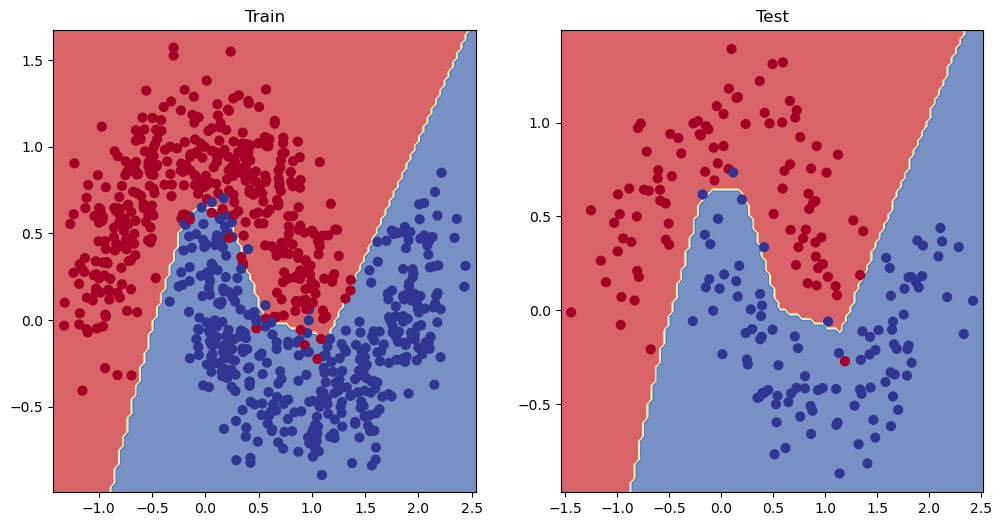

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train_tensor, y_train_tensor)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test_tensor, y_test_tensor)

In [ ]:
# # To run any sklearn.metrics (or any sklearn methods/ classes/ functions/ etc.), must put the tensors back on cpu;

print(classification_report(y_test_tensor.cpu(), y_test_pred_classes.cpu()))

In [ ]:
# Again, for sklearn methods, must convert the tensors to the cpu;

confusion_matrix(y_test_tensor.cpu(), y_test_pred_classes.cpu())

In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [30]:
y_pred.shape

torch.Size([800, 2])

RuntimeError: shape '[101, 101]' is invalid for input of size 20402

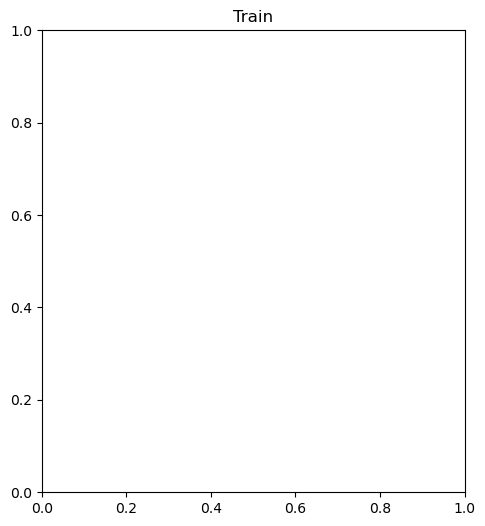

In [15]:
# Step 6: Train the model
# Number of epochs (iterations over the entire dataset)
n_epochs = 100

for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()

    # Forward pass: compute the predictions
    y_pred = model(X_train_tensor)

    # Compute the loss
    loss = criterion(y_pred, y_train_tensor)

    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0741
Epoch [20/100], Loss: 0.0692
Epoch [30/100], Loss: 0.0662
Epoch [40/100], Loss: 0.0640
Epoch [50/100], Loss: 0.0624
Epoch [60/100], Loss: 0.0612
Epoch [70/100], Loss: 0.0604
Epoch [80/100], Loss: 0.0596
Epoch [90/100], Loss: 0.0590
Epoch [100/100], Loss: 0.0585


In [ ]:
# Step 7: Test the model
# Set the model to evaluation mode
model.eval()

# Disable gradient computation during testing for efficiency
with torch.no_grad():
    # Forward pass on the test set
    y_test_pred = model(X_test_tensor)
    # Get the class with the highest score (logits)
    y_test_pred_classes = torch.argmax(y_test_pred, axis=1)


In [23]:
# Step 6: Train the model
# Number of epochs (iterations over the entire dataset)

n_epochs = 100

for epoch in range(n_epochs):
    # Set the model to training mode
    model.train()

    # Forward pass: compute the predictions
    y_pred = model(X_train_tensor)

    # Compute the loss
    loss = criterion(y_pred, y_train_tensor)

    # Zero the gradients from the previous step
    optimizer.zero_grad()

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Print the loss and accuracy every 10 epochs
    if (epoch + 1) % 10 == 0:
        # Calculate accuracy
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            y_pred_classes = torch.argmax(y_pred, dim=1)  # Get predicted class labels
            correct = (y_pred_classes == y_train_tensor).sum().item()  # Count correct predictions
            accuracy = (correct / y_train_tensor.size(0)) *100  # Calculate accuracy
        
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}%")

Epoch [10/100], Loss: 0.0932, Accuracy: 96.0000%
Epoch [20/100], Loss: 0.0823, Accuracy: 96.1250%
Epoch [30/100], Loss: 0.0756, Accuracy: 96.3750%
Epoch [40/100], Loss: 0.0707, Accuracy: 96.7500%
Epoch [50/100], Loss: 0.0679, Accuracy: 97.0000%
Epoch [60/100], Loss: 0.0658, Accuracy: 97.0000%
Epoch [70/100], Loss: 0.0645, Accuracy: 97.0000%
Epoch [80/100], Loss: 0.0633, Accuracy: 97.1250%
Epoch [90/100], Loss: 0.0625, Accuracy: 97.0000%
Epoch [100/100], Loss: 0.0620, Accuracy: 97.1250%


In [26]:
# Step 7: Evaluate the model on the test data
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and correct predictions
test_loss = 0.0
correct = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    # Forward pass: compute the predictions
    y_test_pred = model(X_test_tensor)

    # Compute the loss
    test_loss = criterion(y_test_pred, y_test_tensor).item()

    # Calculate accuracy
    y_test_pred_classes = torch.argmax(y_test_pred, dim=1)  # Get predicted class labels
    correct = (y_test_pred_classes == y_test_tensor).sum().item()  # Count correct predictions
    accuracy = correct / y_test_tensor.size(0)  # Calculate accuracy

# Print test loss and accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 0.0542, Test Accuracy: 0.9750
